# Hyperparameter Sensitivity for Finetuning T5

- It needs to read "FOL2NS.json" for Training and Validation datasets
- It needs to read "FOL2NW_with_predicate.json" for Test dataset
- Change the parameters in the function "validation" to change the strategy

### Catalogue
- Setup
- Functions for Tranining and Validation steps
- Functions for Test step
- Functions for Evaluation
- Model 1: T5-base
- Model 2: T5-large

## Setup

In [4]:
from sklearn.model_selection import train_test_split
from math import ceil, log10
import os
from glob import glob
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from transformers import T5Tokenizer, T5ForConditionalGeneration

In [5]:
FOL2NS_dataset = pd.read_json(
    "FOL2NS.json",
    orient="records",
    lines=True
)

FOL2NW_with_predicate = pd.read_json(
    "FOL2NW_with_predicate.json",
    orient="records",
    lines=True
)

## Functions for Training and Validation steps

In [6]:
def train(train_loader, model, optim, device="cuda"):
    model.train()
    train_loss = []

    for input_ids, labels in tqdm(train_loader, leave=False):
        optim.zero_grad()
        input_ids = input_ids.to(device)
        labels = labels.to(device)
        
        pred_output = model(input_ids=input_ids, labels=labels)
       
        loss = pred_output.loss
        loss.backward()
        optim.step()

        train_loss.append(loss.item())

    return torch.tensor(train_loss).cpu()

In [7]:
# Change the parameters in this function to change the strategy
def validate(dev_loader, model, ifgenerate=True, device="cuda"):
    model.eval()
    dev_loss = []
    token_list=[]
    text_list=[]

    with torch.no_grad():
        for input_dev_ids, dev_labels in tqdm(dev_loader, leave=False):
            input_dev_ids = input_dev_ids.to(device)
            dev_labels = dev_labels.to(device)
            
            output = model(input_ids=input_dev_ids, labels=dev_labels)
            dev_loss.append(output.loss.item())
            
            if ifgenerate:
                # generated_tokens = model.generate(input_dev_ids)
                generated_tokens = model.generate(
                                        input_dev_ids, 
                                        pad_token_id=tokenizer.pad_token_id, 
                                        eos_token_id=tokenizer.eos_token_id,
                                        num_beams=5,
                                        repetition_penalty=1, 
                                        no_repeat_ngram_size=2,
                                        # max_length=64,
                                        early_stopping=True)

                generated_text = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
                for to in generated_tokens:
                    token_list.append(to.tolist())
                text_list.extend(generated_text)

    if ifgenerate:
        return sum(dev_loss) / len(dev_loss), token_list, text_list
    
    return sum(dev_loss) / len(dev_loss), None, None

In [ ]:
def main(n_epochs, batch_size, lr, ifgenerate=True):
    optim = torch.optim.AdamW(model.parameters(), lr=lr)
    lr_string = abs(int(log10(lr)))
    
    train_losses = []
    dev_losses = []
    dev_tokens = []
    dev_text = []
    test_tokens = []
    test_text = []
    
    min_dev_loss = float("inf")
    last_epoch_with_dev_improvement = 0
    early_stopping_threshold = 10

    for epoch_n in tqdm(range(n_epochs)):
        train_loss = train(train_loader, model, optim)
        train_losses.append(train_loss.mean().item())
        
        if (epoch_n + 1) % 10 == 0:
            dev_loss, dev_token_list, dev_text_list = validate(dev_loader, model, ifgenerate)
            dev_losses.append(dev_loss)

            if ifgenerate:
                dev_tokens += dev_token_list
                dev_text.extend(dev_text_list)

            print(f'Epoch {epoch_n+1}, train loss: {train_loss.mean().item():.3f}, dev loss: {dev_loss:.3f}')

            if dev_loss < min_dev_loss:
                print('Saving the model')
                min_dev_loss = dev_loss
                last_epoch_with_dev_improvement = epoch_n

                for path in glob('*.pt'):
                    os.remove(path)
                torch.save(model.state_dict(), f'checkpoint_{batch_size}_{lr_string}.pt')
            else:
                if epoch_n - last_epoch_with_dev_improvement >= early_stopping_threshold:
                    print(f'Early stopping: no improvement for {early_stopping_threshold} epochs.')
                    break
          
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()
    
    plt.plot(dev_losses, label='Dev Loss')
    plt.xlabel("10x Epochs")
    plt.ylabel("Loss")
    plt.show()
    
    # test_tokens, test_texts = test(model, test_loader, device="cuda:1")
    
    if ifgenerate:
        return train_losses, dev_losses, dev_tokens, dev_text#, test_tokens, test_texts
    return train_losses, dev_losses, None, None#, test_tokens, test_texts

## Functions for Test step

In [ ]:
def test(dataset, beam=5, penalty=1, no_repeat_ngram=3, max_len=100, device='cuda:2'):
    model.eval()
    test_token_list = []
    test_text_list = []
    
    dataset = torch.tensor(dataset).to(device)
    
    with torch.no_grad():
        for input_test_ids in tqdm(dataset,leave=False):

            test_generated_tokens = model.generate(
                                        input_ids=input_test_ids.unsqueeze(0),
                                        pad_token_id=tokenizer.pad_token_id,
                                        eos_token_id=tokenizer.eos_token_id,
                                        num_beams=beam,
                                        repetition_penalty=penalty,
                                        no_repeat_ngram_size=no_repeat_ngram,
                                        early_stopping=True,
                                        max_length=max_len
                                    )

            test_generated_text = tokenizer.batch_decode(test_generated_tokens, skip_special_tokens=True)

            for to in test_generated_tokens:
                test_token_list.append(to.tolist())  
            test_text_list.extend(test_generated_text)  

    return test_token_list, test_text_list

## Functions for Evaluation

### 1. Edit Distance

In [ ]:
def minDistance(token1, token2):
    dp = [[0] * (len(token2)+1) for _ in range(len(token1)+1)]

    for i in range(len(token1)+1):
        dp[i][0]=i
    for j in range(len(token2)+1):
        dp[0][j]=j

    for i in range(1, len(token1)+1):
        for j in range(1, len(token2)+1):
            if token1[i-1] == token2[j-1]:
                dp[i][j] = dp[i-1][j-1]
            else:
                v1 = dp[i-1][j]
                v2 = dp[i][j-1]
                v3 = dp[i-1][j-1]
                min_value = min(v1, v2, v3)+1
                dp[i][j] = min_value

    return dp[len(token1)][len(token2)]

In [ ]:
def evaluation_with_minDistance(pred_dataset, gold_dataset, distance_fn, normalize=True, filter_empty=True):
    total_minDis = 0
    total_score = 0
    count = 0
    skipped = 0

    for pred, gold in zip(pred_dataset, gold_dataset):
        pred = str(pred).strip()
        gold = str(gold).strip()

        if filter_empty:
            if not pred or not gold or all(token in ["<pad>", ""] for token in pred.split()):
                skipped += 1
                continue

        dis = distance_fn(pred, gold)
        total_minDis += dis

        if normalize:
            base_len = max(len(pred.split()), len(gold.split()))
            score = dis / base_len if base_len > 0 else 0
            total_score += score
        else:
            total_score += dis

        count += 1

    avg_dist = total_minDis / count if count > 0 else float("inf")
    avg_score = total_score / count if count > 0 else float("inf")

    print(f"Total samples: {len(pred_dataset)}, evaluated: {count}, skipped: {skipped}")
    return avg_dist, avg_score

### 2. BLEU

In [ ]:
def get_ngrams(sentence_toks,n):
  ngrams = defaultdict(int)  
  for i in range(0,len(sentence_toks)-(n-1)):
    ngrams[str.join(" ",sentence_toks[i:i+n])]+=1
  return(ngrams)

In [ ]:
def get_clipped_counts(h,r,n):
    counts = get_ngrams(h, n)
    reference_counts = get_ngrams(r, n)
    clipped_counts = [min(count, reference_counts[ngram]) for ngram, count in counts.items()]
    return sum(clipped_counts)/(sum(counts.values())+0.001)

In [ ]:
def brevity_penalty(h, r):
    return float(min(1,np.exp(1-len(r)/(len(h)+0.001))))

In [ ]:
def compute_bleu(h, r, n):
    precisions = [get_clipped_counts(h, r, n) for n in range(1, n+1)]
    log_precisions = [np.log(p) if p > 0 else -9999 for p in precisions] 
    bleu = brevity_penalty(h, r) * np.exp(sum(log_precisions) / n)
    return bleu

### 3. Print Final Results

In [ ]:
def final_result(text, gold_text):
    avg_dist, avg_score = evaluation_with_minDistance(text, gold_text, minDistance, normalize=True)
    bleu_scores = [compute_bleu(h.split(), r.split(),1) for h, r in zip(text, gold_text)]
    print(f"Average Distance:{avg_dist}; Average Score:{avg_score}")
    print(f"Average BLEU:{sum(bleu_scores) / len(bleu_scores)}")

    print("\nThe first five samples:")
    for i in range(5):
        print("Input:", input_text[i])
        print("Output:", text[i])
        print("Target:", gold_text[i])
        print("Distance:", minDistance(text[i], gold_text[i]))
        print("BLEU:",compute_bleu(text[i], gold_text[i], 1),"\n")

# Model 1: T5-base

In [ ]:
tokenizer = T5Tokenizer.from_pretrained("google-t5/t5-base")
model = T5ForConditionalGeneration.from_pretrained("google-t5/t5-base").to("cuda")

In [ ]:
Train, Dev = train_test_split(FOL2NS_dataset, test_size=0.2, random_state=30, shuffle=True)
X_train, Y_train = Train['input'].tolist(), Train['output'].tolist()
X_dev, Y_dev = Dev['input'].tolist(), Dev['output'].tolist()

In [ ]:
x_train = tokenized_text(X_train)
y_train = tokenized_text(Y_train)
x_dev = tokenized_text(X_dev)
y_dev = tokenized_text(Y_dev)

y_train[y_train == tokenizer.pad_token_id] = -100
y_dev[y_dev == tokenizer.pad_token_id] = -100

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(x_train, y_train)
dev_dataset = TensorDataset(x_dev, y_dev)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=1, pin_memory=True)
dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False, num_workers=1, pin_memory=True)

### 1. The version of standard T5
- Need to change the "model.generate" in the function "validation"

In [ ]:
# train_losses, dev_losses, tokens, text = main(n_epochs=30, batch_size=32, lr=10**(-4))

**Related Result**
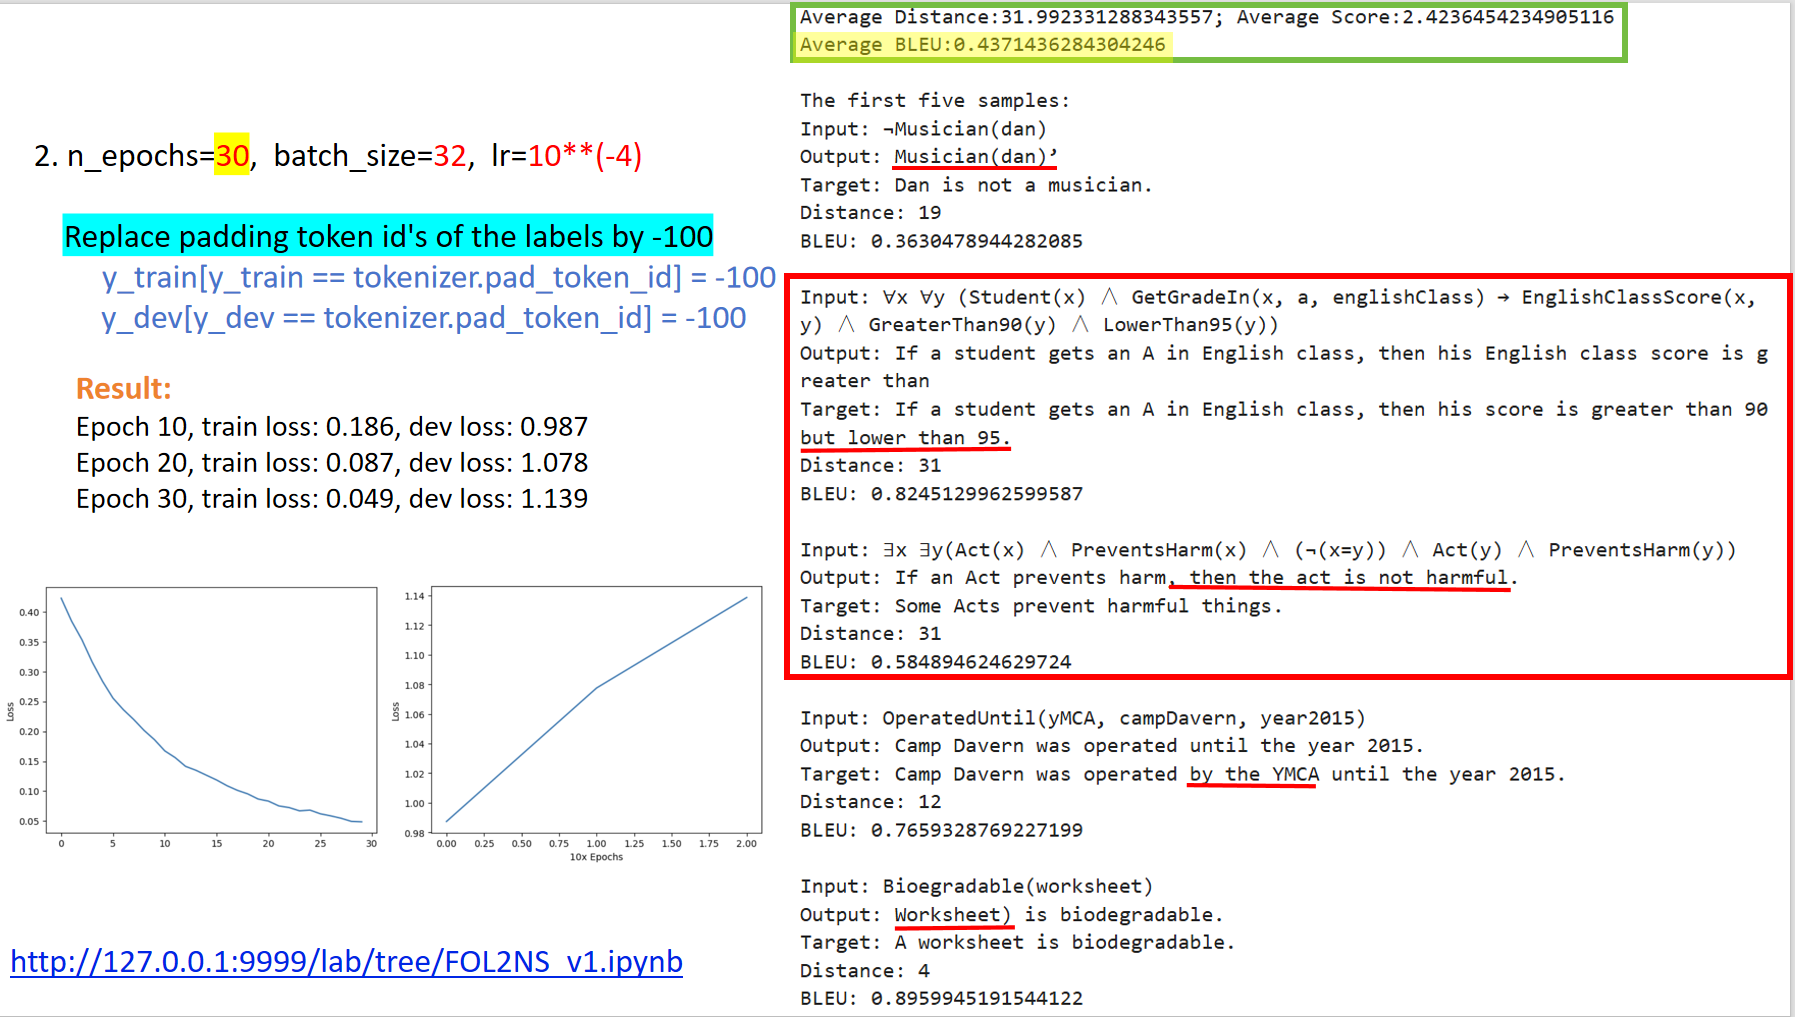

In [ ]:
# train_losses, dev_losses, tokens, text = main(n_epochs=30, batch_size=32, lr=10**(-5))

**Related Result**
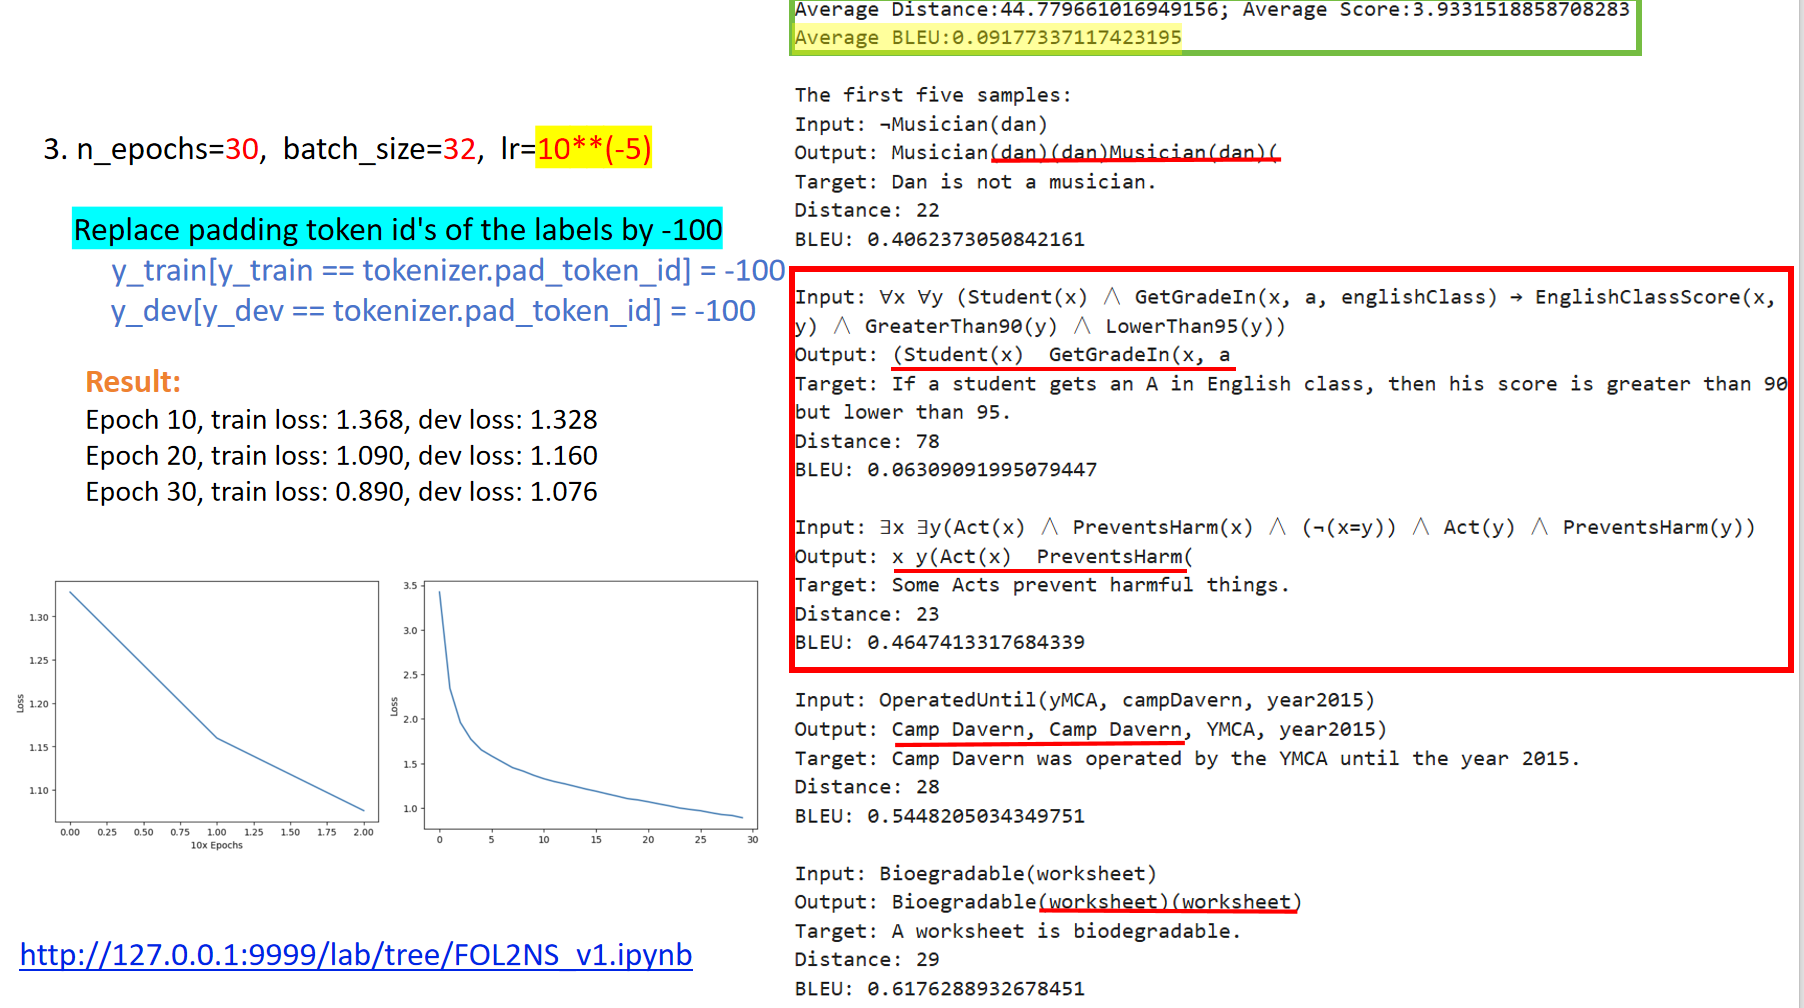

### 2. The version of adjusted "model.generate"

In [2]:
# The optimal configration in T5-base
train_losses, dev_losses, tokens, text = main(n_epochs=30, batch_size=32, lr=10**(-4))

**Related Result**
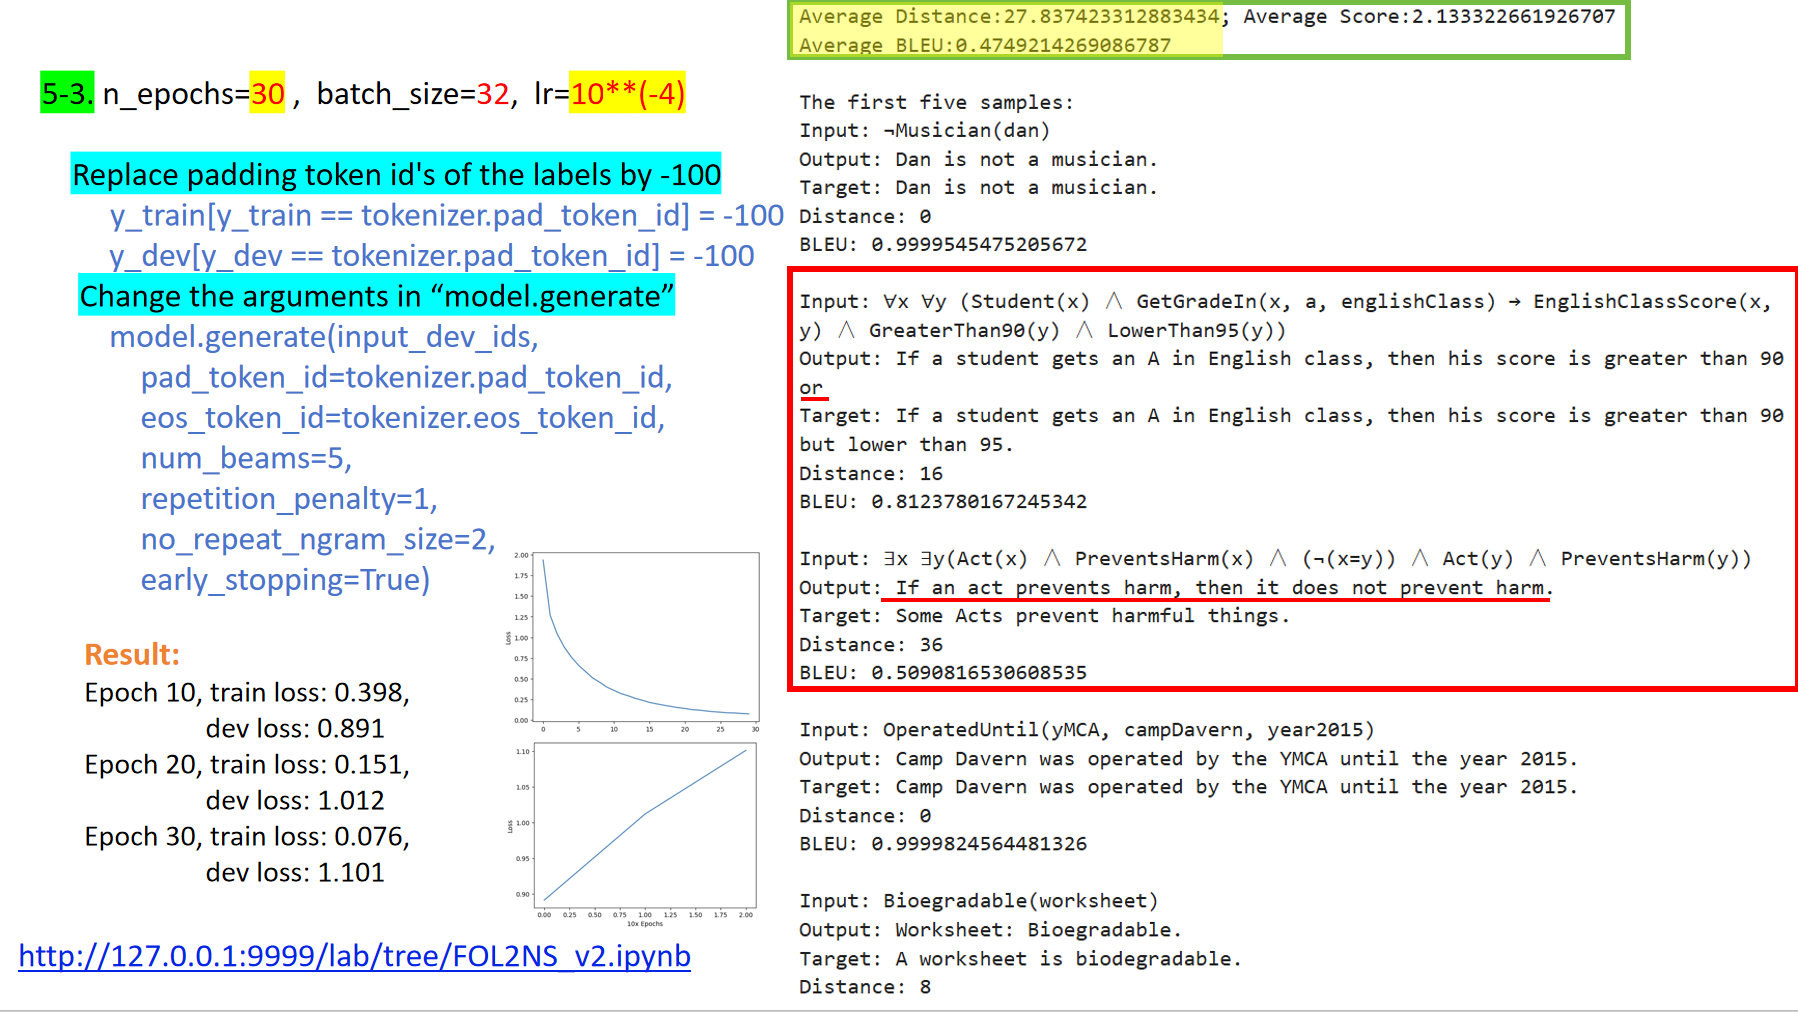

In [ ]:
# train_losses, dev_losses, tokens, text = main(n_epochs=25, batch_size=32, lr=10**(-4))

**Related Result**
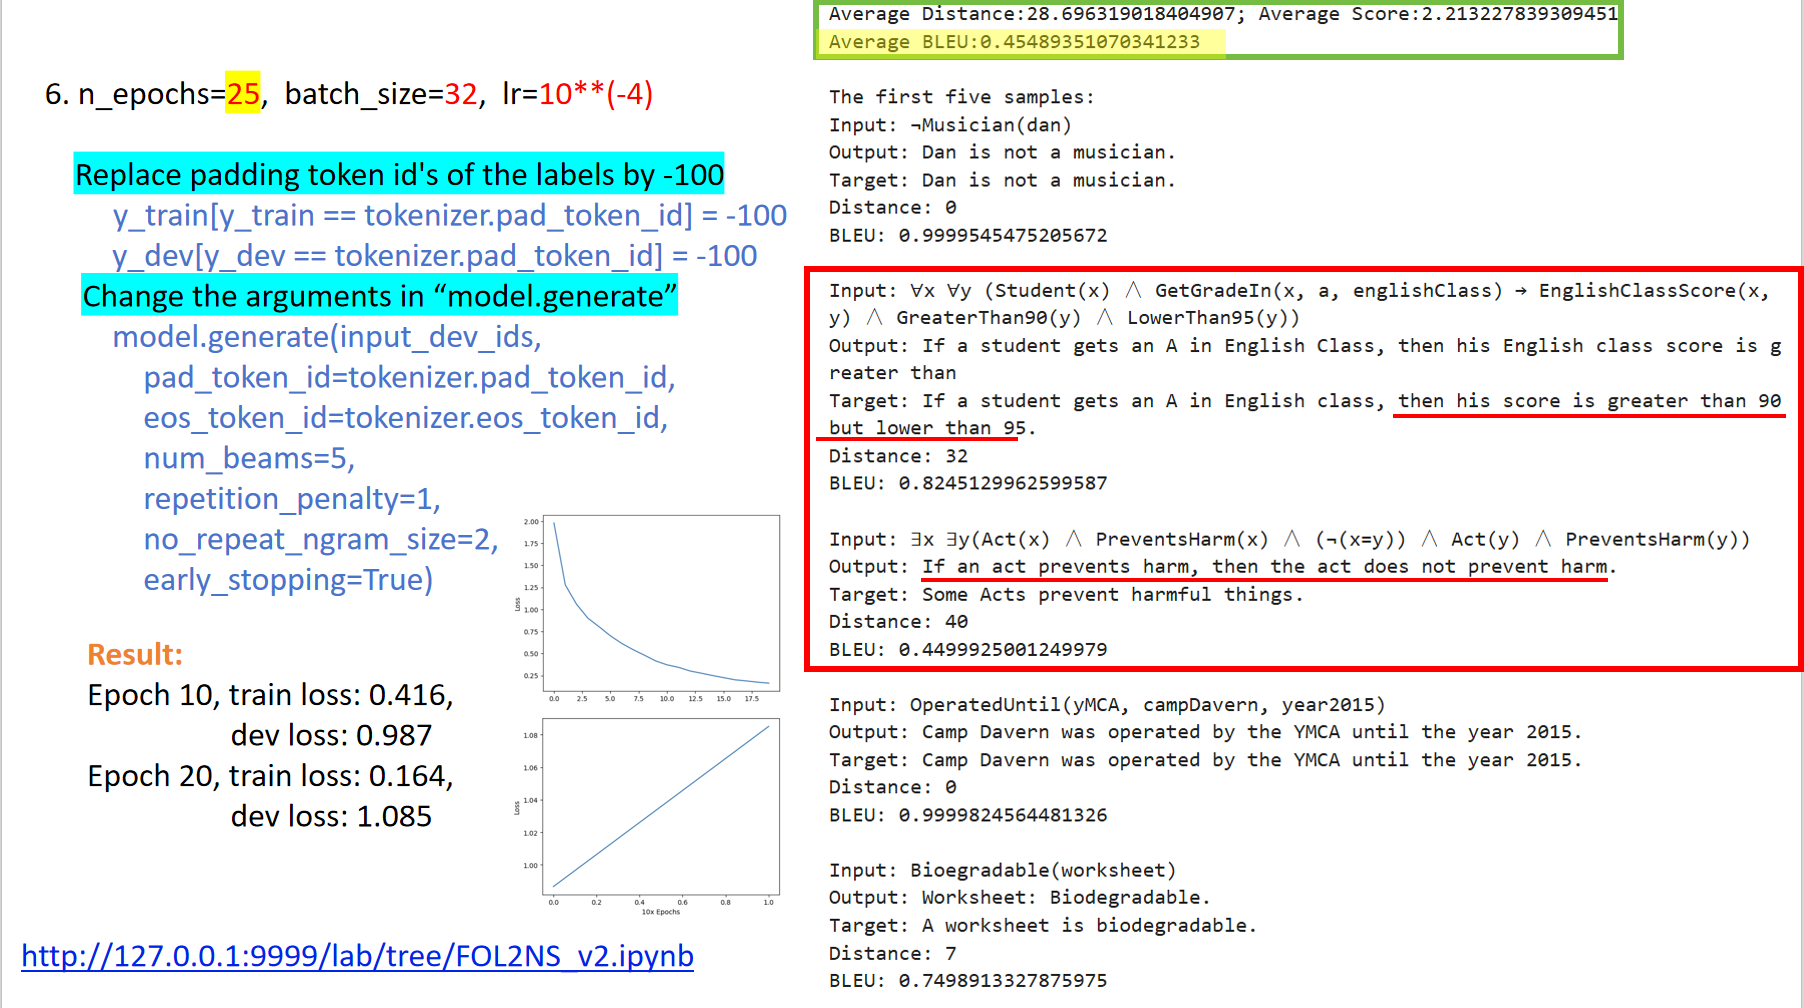

In [ ]:
# train_losses, dev_losses, tokens, text = main(n_epochs=20, batch_size=32, lr=10**(-4))

**Related Result**
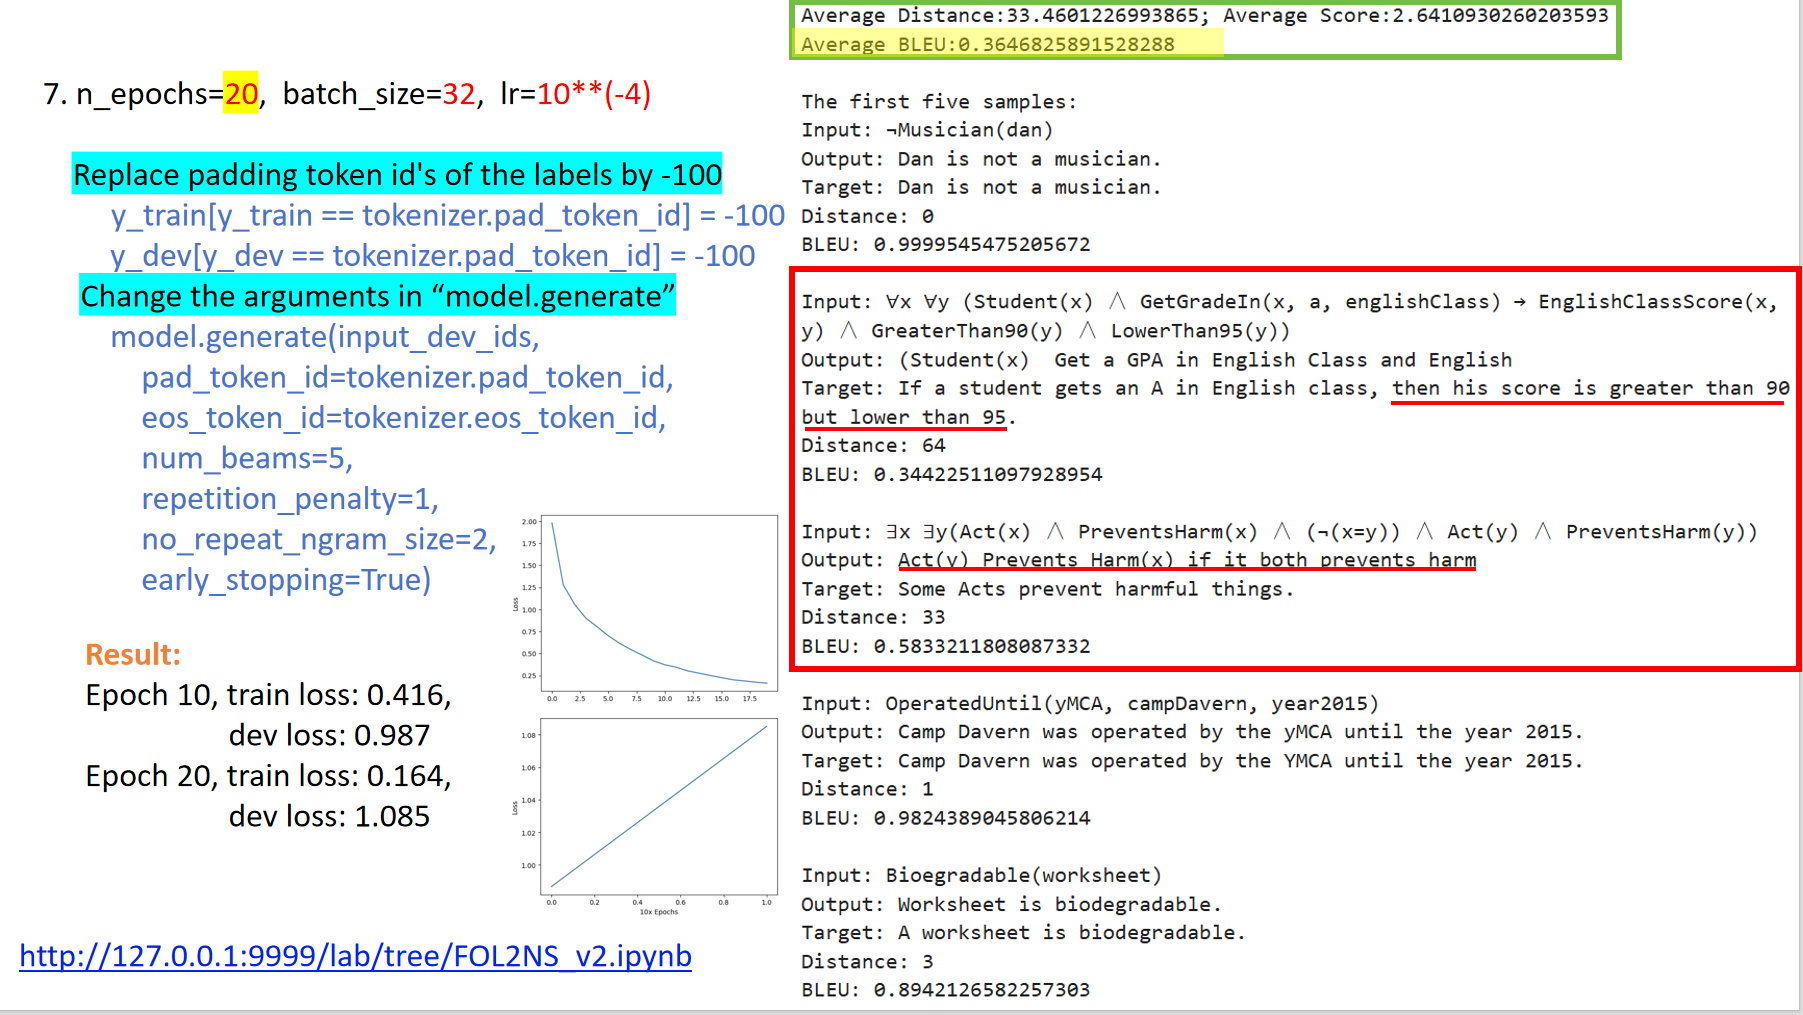

### 3. The version of adding Prefix in T5

In [ ]:
prefix = "Translate FOL formula to English: "

In [ ]:
X_train_prefix = [prefix + text for text in X_train]
X_dev_prefix = [prefix + text for text in X_dev]

In [ ]:
x_train = tokenized_text(X_train_prefix)
y_train = tokenized_text(Y_train)
x_dev = tokenized_text(X_dev_prefix)
y_dev = tokenized_text(Y_dev)

y_train[y_train == tokenizer.pad_token_id] = -100
y_dev[y_dev == tokenizer.pad_token_id] = -100

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(x_train, y_train)
dev_dataset = TensorDataset(x_dev, y_dev)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=1, pin_memory=True)
dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False, num_workers=1, pin_memory=True)

In [ ]:
torch.cuda.empty_cache() 

In [ ]:
# train_losses, dev_losses, tokens, text = main(n_epochs=50, batch_size=32, lr=10**(-4))

**Related Result**
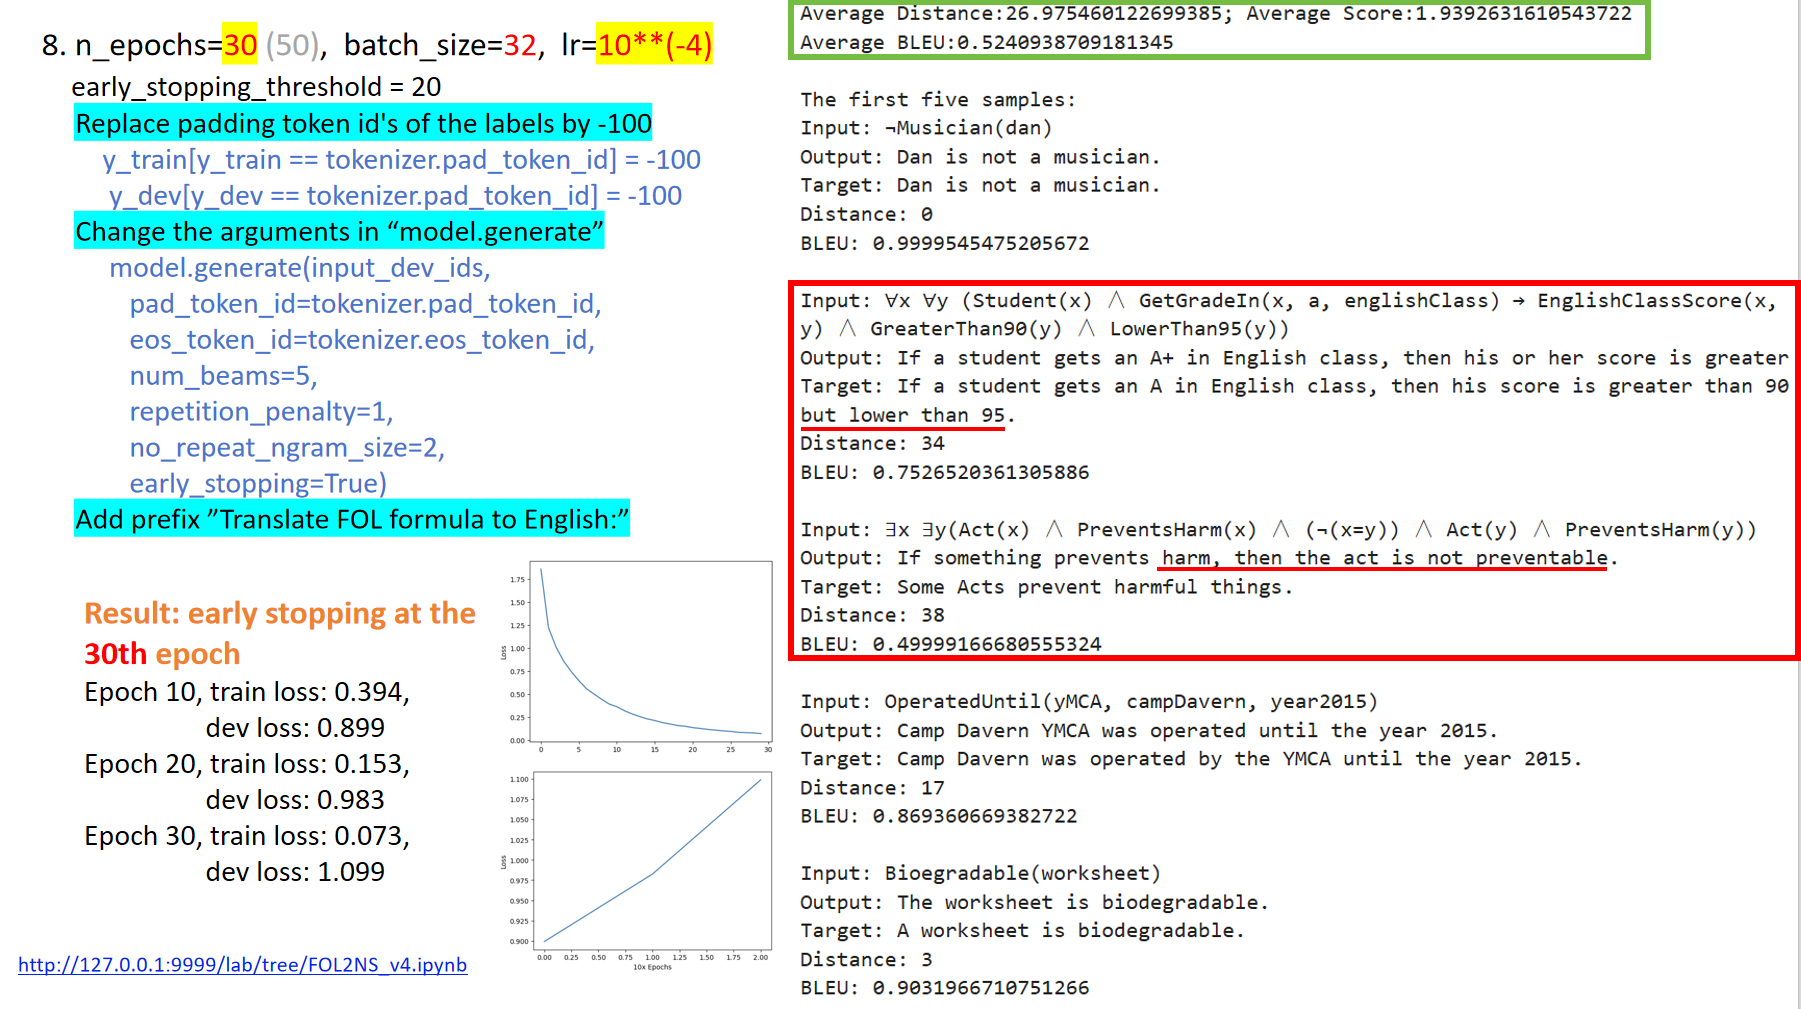
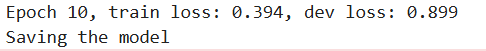
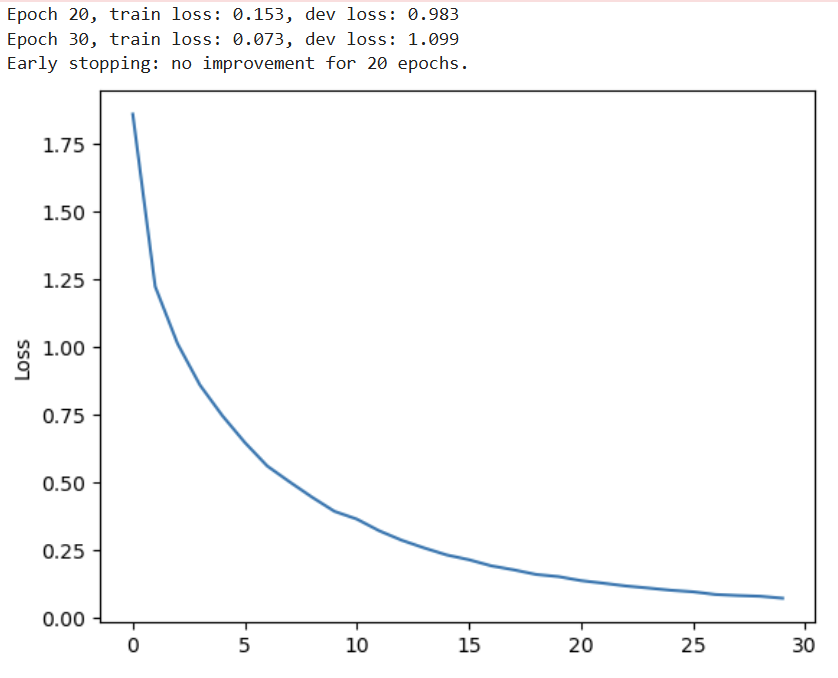
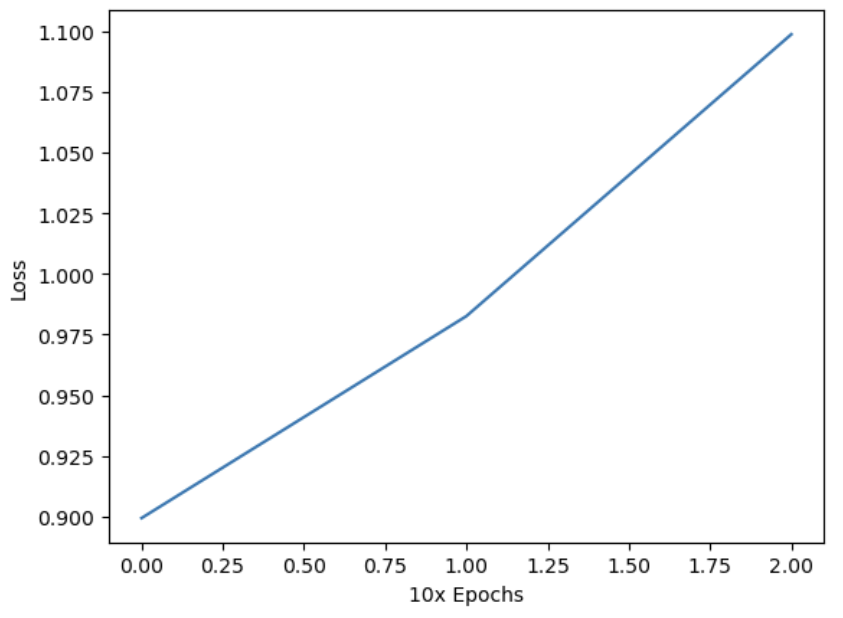

In [ ]:
input_text = X_dev
gold_text = Y_dev

In [ ]:
# final_result(text, gold_text)

**Related Result**
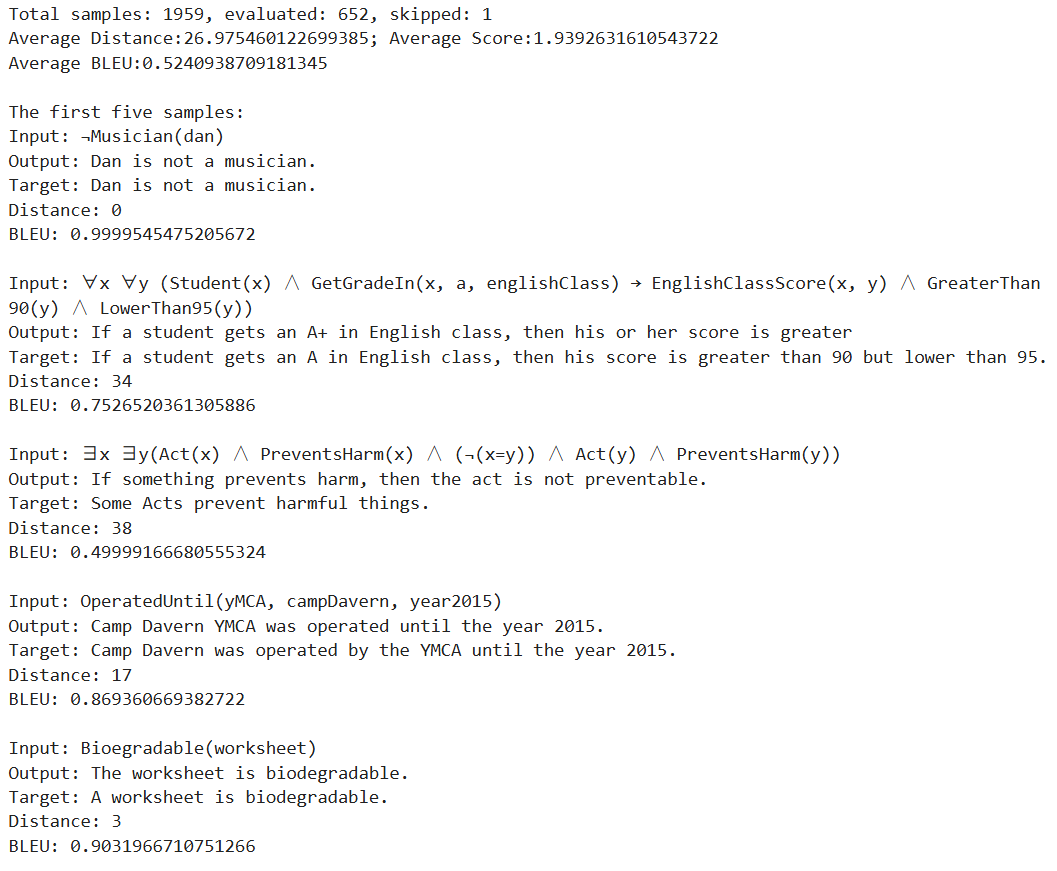

# Model 2: T5-large

### 1. Tokenizer
- Add the special tokens needed in FOL
- Replace the special tokens with related English phrases
- Retokenizer

In [ ]:
tokenizer = T5Tokenizer.from_pretrained("google-t5/t5-large")
model = T5ForConditionalGeneration.from_pretrained("google-t5/t5-large").to("cuda")

In [ ]:
symbol_ls = ['<¬>', '<∀>', '<∃>', '<⊕>', '<→>', '<∧>', '<∨>']
for i in symbol_ls:
    # check_tokenizer = tokenizer.encode(i, add_special_tokens=False)
    token_id = tokenizer.convert_tokens_to_ids(i)
    if token_id != tokenizer.unk_token_id:
        print(f"{i}: {token_id}")
    else:
        print("None")

In [ ]:
tokenizer.add_tokens(['<¬>', '<∀>', '<∃>', '<⊕>', '<→>', '<∧>', '<∨>'])
model.resize_token_embeddings(len(tokenizer))

In [ ]:
print("Tokenizer length:", len(tokenizer))
for tok in symbol_ls:
    print(tok, "->", tokenizer.encode(tok, add_special_tokens=False))

In [ ]:
replace_dict = {
        '¬': 'No ',
        '∀': 'For All ', 
        '∃': 'There Exists ', 
        '⊕': 'XOR ', 
        '→': 'implies', 
        '∧':'and', 
        '∨':'or'
}

FOL2NS_dataset["input"] = FOL2NS_dataset["input"].apply(lambda x: x.translate(str.maketrans(replace_dict)))    

In [ ]:
Train, Dev = train_test_split(FOL2NS_dataset, test_size=0.2, random_state=30, shuffle=True)
X_train, Y_train = Train['input'].tolist(), Train['output'].tolist()
X_dev, Y_dev = Dev['input'].tolist(), Dev['output'].tolist()

In [ ]:
def tokenized_text(text):
  tokenization = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
  return tokenization.input_ids

x_train = tokenized_text(X_train)
y_train = tokenized_text(Y_train)
x_dev = tokenized_text(X_dev)
y_dev = tokenized_text(Y_dev)

y_train[y_train == tokenizer.pad_token_id] = -100
y_dev[y_dev == tokenizer.pad_token_id] = -100

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(x_train, y_train)
dev_dataset = TensorDataset(x_dev, y_dev)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=1, pin_memory=True)
dev_loader = DataLoader(dev_dataset, batch_size=8, shuffle=False, num_workers=1, pin_memory=True)

In [ ]:
FOL2NW_with_predicate["FOL2NW"] = FOL2NW_with_predicate["FOL2NW"].apply(lambda x: x.translate(str.maketrans(replace_dict))) 

In [ ]:
X_test = FOL2NW_with_predicate['FOL2NW'].tolist()
x_test = tokenized_text(X_test)

test_dataset = TensorDataset(x_test)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=1, pin_memory=True)

### 2. Main Experiments

In [ ]:
torch.cuda.empty_cache()

In [ ]:
train_losses, dev_losses, dev_tokens, dev_text= main(n_epochs=20, batch_size=8, lr=10**(-4))

**Related Result**
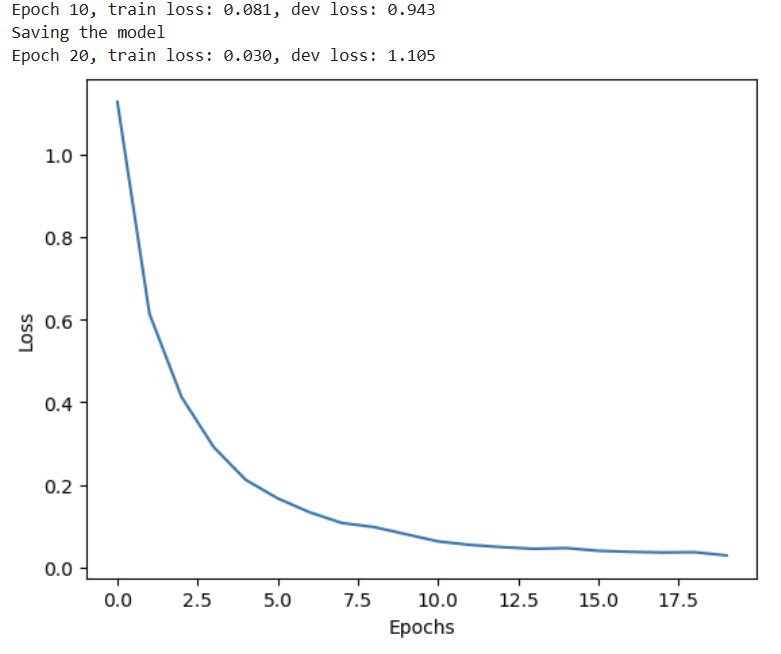
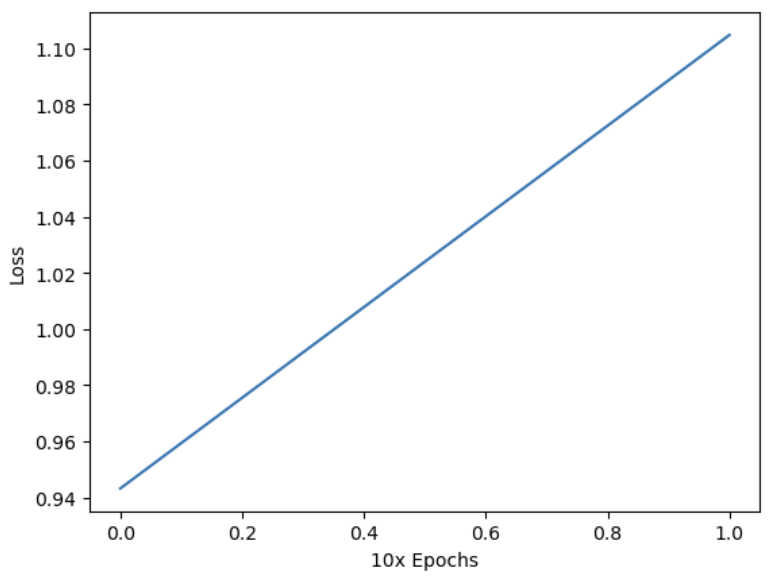

In [ ]:
test_token_list, test_text_list = test(x_test)

In [ ]:
FOL2NW_text = X_test

for i in range(10):
        print("FOL2NW:", FOL2NW_text[i])
        print("-->", test_text_list[i],"\n")

**Related Result**
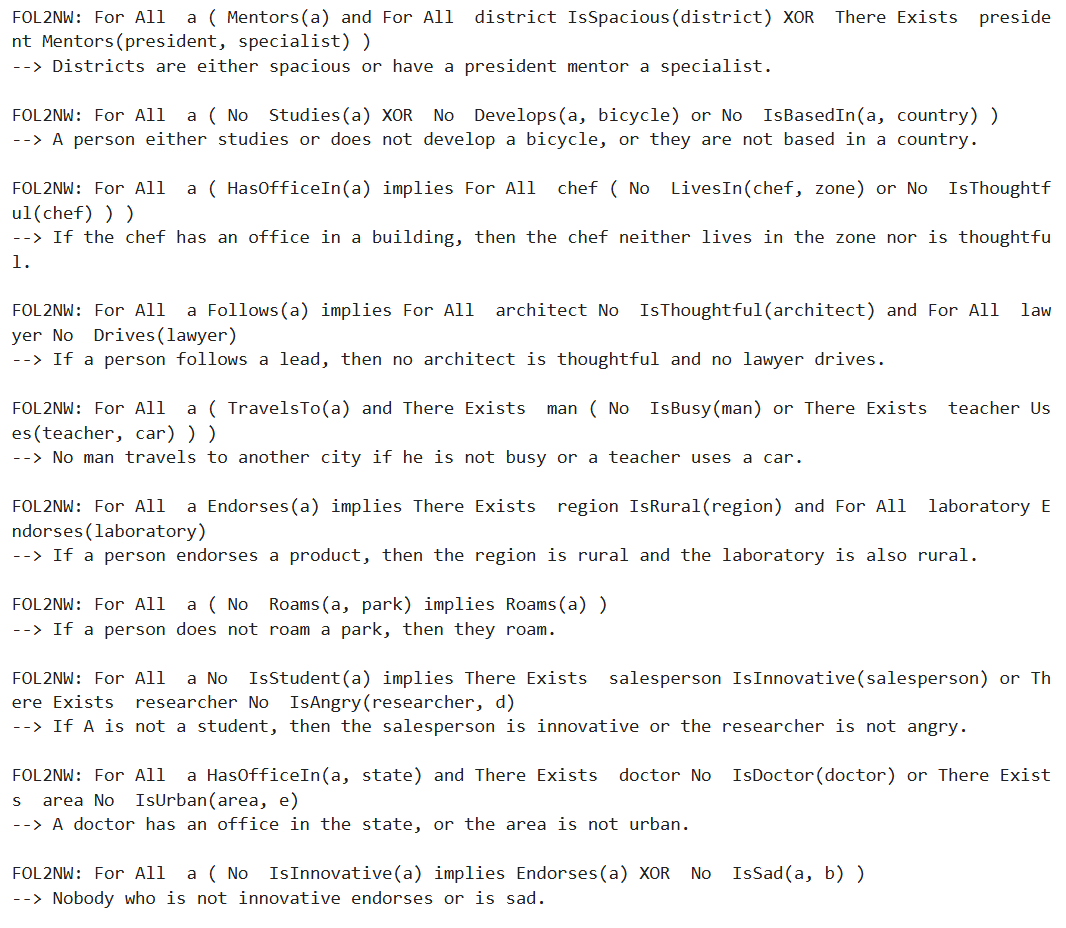

In [ ]:
input_text = X_dev
gold_text = Y_dev

In [ ]:
final_result(dev_text, gold_text)

**Related Result**

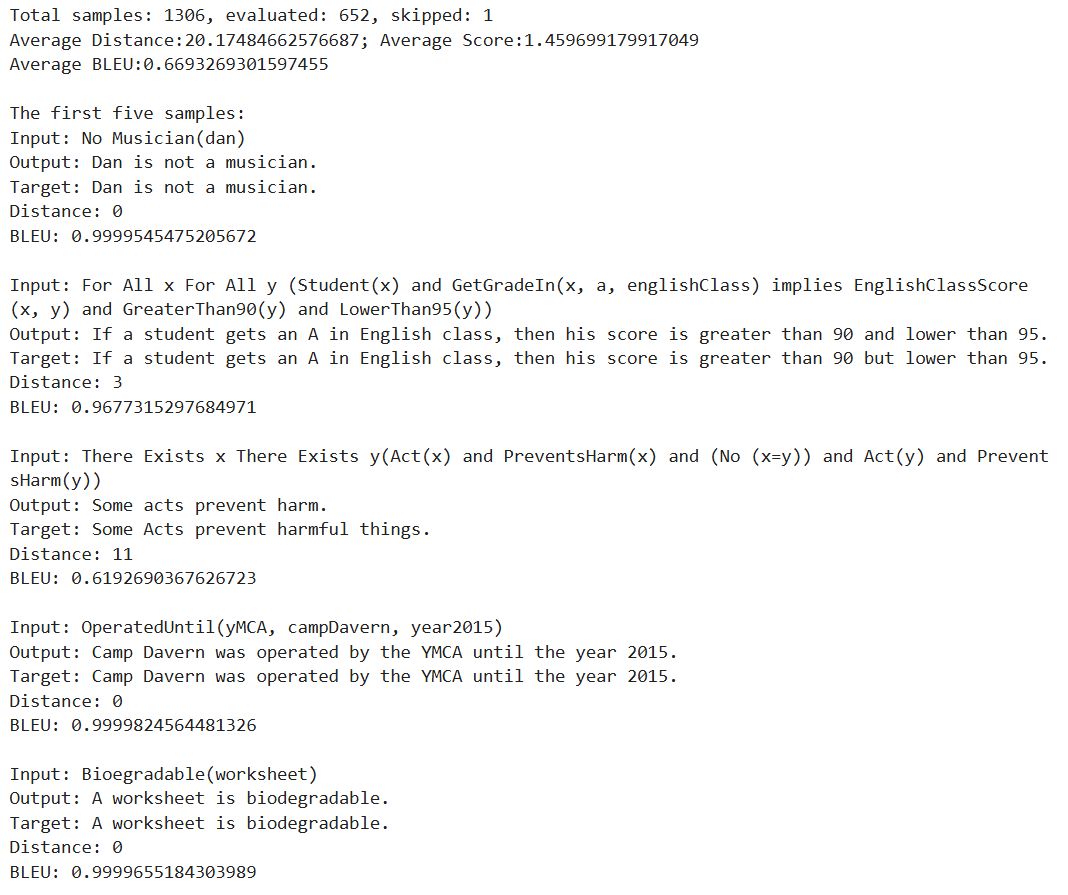

In [ ]:
# def test(model, test_loader, device="cuda:2"):
#     model.eval()
#     token_list=[]
#     text_list=[]

#     with torch.no_grad():
#         # for input_test_ids in tqdm(test_loader, leave=False):
#             # input_test_ids = input_test_ids[0].to(device)
#             test_loader = test_loader.to(device)
#             # print(input_test_ids)
            
#             generated_tokens = model.generate(
#                                     input_test_ids, 
#                                     # pad_token_id=tokenizer.pad_token_id, 
#                                     # eos_token_id=tokenizer.eos_token_id,
#                                     num_beams=5,
#                                     repetition_penalty=1, 
#                                     no_repeat_ngram_size=2,
#                                     early_stopping=True)

#             generated_text = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
#             for to in generated_tokens:
#                 token_list.append(to.tolist())
#             text_list.extend(generated_text)
    
#     return token_list, text_list